## Read data matrix

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'omop_cdm'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [2]:
dataQuery = """select * from sepsis_micro.data_matrix;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,visit_occurrence_concept_name,visit_duration_hrs,visit_source_concept_name,admitting_source_value,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,...,bicarbonate_last,hemoglobin_last,creatinine_last,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality
0,9769904,-1046091425,Emergency Room - Hospital,282.0,DIRECT EMER.,CLINIC REFERRAL,99.7,121.0,NaN,NaN,...,23.0,10.1,0.7,False,False,False,False,False,False,False
1,2985612,697543230,Emergency Room - Hospital,359.0,EW EMER.,EMERGENCY ROOM,99.7,141.0,NaN,NaN,...,19.0,10.0,1.0,False,False,False,False,False,False,False
2,2871076,428913244,Emergency Room - Hospital,122.0,EW EMER.,EMERGENCY ROOM,37.0,NaN,NaN,NaN,...,25.0,14.0,0.8,False,False,False,False,False,False,False
3,6894504,-1600246244,Emergency Room - Hospital,997.0,DIRECT EMER.,PHYSICIAN REFERRAL,98.4,108.0,NaN,NaN,...,25.0,11.3,0.6,False,False,False,False,True,True,True
4,8752252,431197671,Ambulatory Surgical Center,282.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,102.3,132.0,12.0,35.0,...,24.0,8.6,0.7,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,1866973,2023686478,Emergency Room and Inpatient Visit,1289.0,URGENT,TRANSFER FROM HOSPITAL,103.1,134.0,NaN,33.0,...,18.0,8.6,1.6,False,False,False,False,False,False,False
7335,2124103,2023686478,Emergency Room - Hospital,339.0,EW EMER.,EMERGENCY ROOM,98.5,127.0,NaN,NaN,...,22.0,10.1,0.4,False,False,False,False,False,False,False
7336,5256383,2023686478,Emergency Room and Inpatient Visit,1289.0,URGENT,TRANSFER FROM HOSPITAL,101.0,130.0,30.0,0.0,...,24.0,10.2,1.8,False,False,False,False,False,False,False
7337,2268946,1484033855,Emergency Room - Hospital,601.0,EW EMER.,EMERGENCY ROOM,101.5,101.0,0.0,37.0,...,30.0,9.1,0.8,False,False,False,False,False,False,False


## Missing data

In [3]:
dataDf.isna().sum().sort_values()

micro_specimen_id               0
sixty_day_mortality             0
twentyeight_day_mortality       0
twentyone_day_mortality         0
fourteen_day_mortality          0
                             ... 
meanbp_max                   4950
meanbp_first                 4950
meanbp_avg                   4950
meanbp_sd                    4960
breath_rate_vent_sd          4962
Length: 145, dtype: int64

<AxesSubplot:>

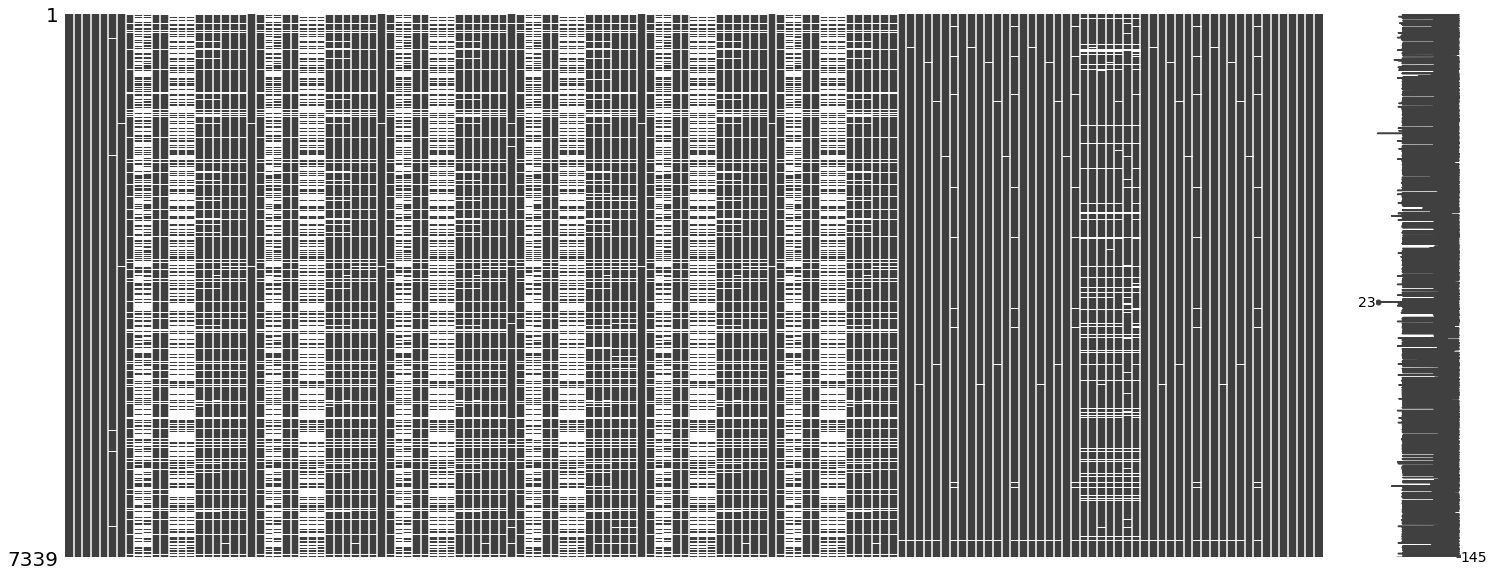

In [4]:
import missingno as msno

msno.matrix(dataDf)

<AxesSubplot:>

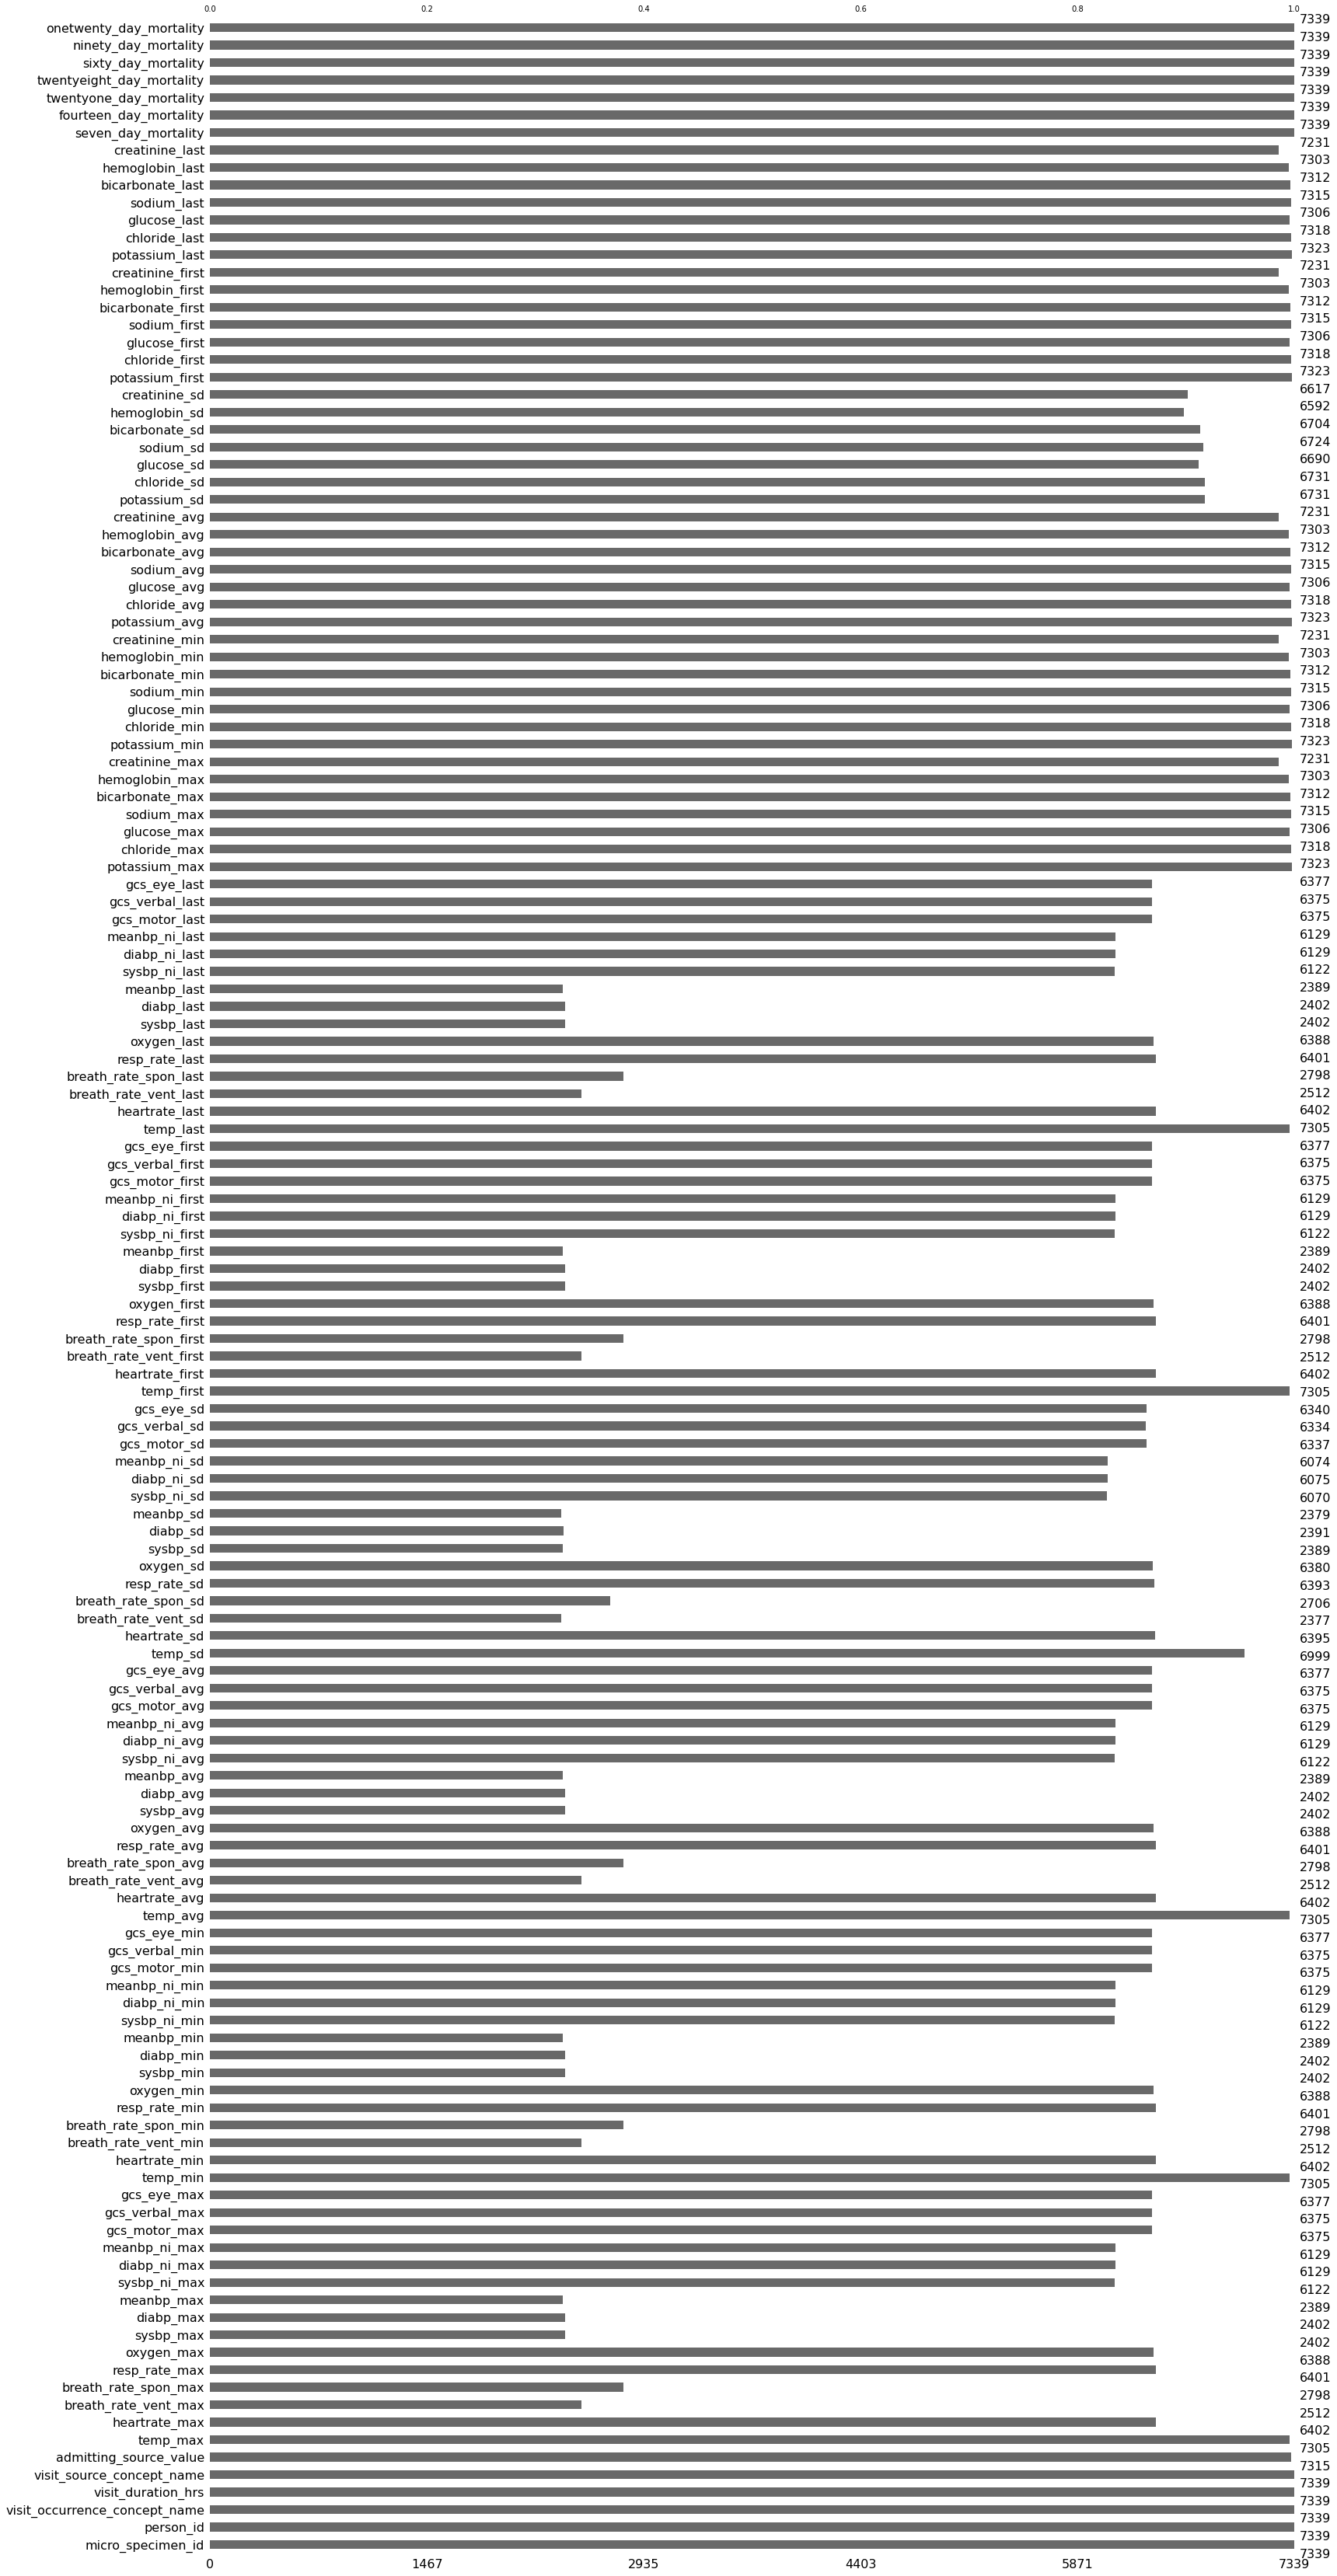

In [5]:
import missingno as msno

msno.bar(dataDf)

## One-hot-encode categorical columns

In [6]:
for catCol in ['visit_occurrence_concept_name', 'visit_source_concept_name', 'admitting_source_value']:
    dummyDf = pd.get_dummies(dataDf[catCol])
    dataDf.drop(catCol, axis = 1, inplace=True)
    dataDf = dataDf.join(dummyDf)
dataDf

,micro_specimen_id,person_id,visit_duration_hrs,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,resp_rate_max,oxygen_max,sysbp_max,...,CLINIC REFERRAL,EMERGENCY ROOM,INFORMATION NOT AVAILABLE,INTERNAL TRANSFER TO OR FROM PSYCH,PACU,PHYSICIAN REFERRAL,PROCEDURE SITE,TRANSFER FROM HOSPITAL,TRANSFER FROM SKILLED NURSING FACILITY,WALK-IN/SELF REFERRAL
0,9769904,-1046091425,282.0,99.7,121.0,NaN,NaN,28.0,99.0,135.0,...,1,0,0,0,0,0,0,0,0,0
1,2985612,697543230,359.0,99.7,141.0,NaN,NaN,23.0,100.0,135.0,...,0,1,0,0,0,0,0,0,0,0
2,2871076,428913244,122.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
3,6894504,-1600246244,997.0,98.4,108.0,NaN,NaN,29.0,100.0,174.0,...,0,0,0,0,0,1,0,0,0,0
4,8752252,431197671,282.0,102.3,132.0,12.0,35.0,39.0,100.0,117.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,1866973,2023686478,1289.0,103.1,134.0,NaN,33.0,36.0,100.0,156.0,...,0,0,0,0,0,0,0,1,0,0
7335,2124103,2023686478,339.0,98.5,127.0,NaN,NaN,29.0,99.0,168.0,...,0,1,0,0,0,0,0,0,0,0
7336,5256383,2023686478,1289.0,101.0,130.0,30.0,0.0,36.0,100.0,142.0,...,0,0,0,0,0,0,0,1,0,0
7337,2268946,1484033855,601.0,101.5,101.0,0.0,37.0,29.0,100.0,158.0,...,0,1,0,0,0,0,0,0,0,0


## Standardise

In [7]:
cols = ["visit_duration_hrs", "temp_max", "heartrate_max", "breath_rate_vent_max", "breath_rate_spon_max", "resp_rate_max", "oxygen_max", "sysbp_max", "diabp_max", "meanbp_max", "sysbp_ni_max", "diabp_ni_max", "meanbp_ni_max", "gcs_motor_max", "gcs_verbal_max", "gcs_eye_max", "temp_min", "heartrate_min", "breath_rate_vent_min", "breath_rate_spon_min", "resp_rate_min", "oxygen_min", "sysbp_min", "diabp_min", "meanbp_min", "sysbp_ni_min", "diabp_ni_min", "meanbp_ni_min", "gcs_motor_min", "gcs_verbal_min", "gcs_eye_min", "temp_avg", "heartrate_avg", "breath_rate_vent_avg", "breath_rate_spon_avg", "resp_rate_avg", "oxygen_avg", "sysbp_avg", "diabp_avg", "meanbp_avg", "sysbp_ni_avg", "diabp_ni_avg", "meanbp_ni_avg", "gcs_motor_avg", "gcs_verbal_avg", "gcs_eye_avg", "temp_sd", "heartrate_sd", "breath_rate_vent_sd", "breath_rate_spon_sd", "resp_rate_sd", "oxygen_sd", "sysbp_sd", "diabp_sd", "meanbp_sd", "sysbp_ni_sd", "diabp_ni_sd", "meanbp_ni_sd", "gcs_motor_sd", "gcs_verbal_sd", "gcs_eye_sd", "temp_first", "heartrate_first", "breath_rate_vent_first", "breath_rate_spon_first", "resp_rate_first", "oxygen_first", "sysbp_first", "diabp_first", "meanbp_first", "sysbp_ni_first", "diabp_ni_first", "meanbp_ni_first", "gcs_motor_first", "gcs_verbal_first", "gcs_eye_first", "temp_last", "heartrate_last", "breath_rate_vent_last", "breath_rate_spon_last", "resp_rate_last", "oxygen_last", "sysbp_last", "diabp_last", "meanbp_last", "sysbp_ni_last", "diabp_ni_last", "meanbp_ni_last", "gcs_motor_last", "gcs_verbal_last", "gcs_eye_last", "potassium_max", "chloride_max", "glucose_max", "sodium_max", "bicarbonate_max", "hemoglobin_max", "creatinine_max", "potassium_min", "chloride_min", "glucose_min", "sodium_min", "bicarbonate_min", "hemoglobin_min", "creatinine_min", "potassium_avg", "chloride_avg", "glucose_avg", "sodium_avg", "bicarbonate_avg", "hemoglobin_avg", "creatinine_avg", "potassium_sd", "chloride_sd", "glucose_sd", "sodium_sd", "bicarbonate_sd", "hemoglobin_sd", "creatinine_sd", "potassium_first", "chloride_first", "glucose_first", "sodium_first", "bicarbonate_first", "hemoglobin_first", "creatinine_first", "potassium_last", "chloride_last", "glucose_last", "sodium_last", "bicarbonate_last", "hemoglobin_last", "creatinine_last"]

In [8]:
from sklearn.preprocessing import StandardScaler

data = StandardScaler().fit_transform(dataDf[cols])
standardDf = pd.DataFrame(data, columns = cols)
standardDf

,visit_duration_hrs,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,resp_rate_max,oxygen_max,sysbp_max,diabp_max,meanbp_max,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,-0.232237,0.380139,0.297486,NaN,NaN,-0.557796,-0.672312,-0.530760,-0.310921,-0.484047,...,0.232437,0.672591,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177
1,-0.138922,0.380139,1.282899,NaN,NaN,-1.454760,0.394172,-0.530760,-0.086355,-0.252468,...,-0.905166,-1.303816,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477
2,-0.426139,-2.457541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.232437,-0.391629,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943
3,0.634263,0.321304,-0.343032,NaN,NaN,-0.378404,0.394172,1.266410,1.036478,0.673846,...,-0.146764,0.723268,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410
4,-0.232237,0.497810,0.839463,-1.440497,1.159637,1.415524,0.394172,-1.360223,-0.011499,-1.120888,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,0.988134,0.534017,0.938005,NaN,1.005909,0.877346,0.394172,0.436947,-0.535488,-0.368258,...,-1.094767,-0.645014,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076
7335,-0.163160,0.325830,0.593110,NaN,NaN,-0.378404,-0.672312,0.989923,1.335900,1.947529,...,0.422038,0.368528,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877
7336,0.988134,0.438975,0.740922,1.549473,-1.530607,0.877346,0.394172,-0.208191,0.213067,-0.194574,...,-1.094767,0.925976,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391
7337,0.154355,0.461604,-0.687927,-3.433811,1.313365,-0.378404,0.394172,0.529110,0.437634,0.384373,...,0.801239,-0.391629,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943


In [9]:
dataDf = dataDf.drop(cols, axis = 1).join(standardDf)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,9769904,-1046091425,False,False,False,False,False,False,False,0,...,0.232437,0.672591,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177
1,2985612,697543230,False,False,False,False,False,False,False,0,...,-0.905166,-1.303816,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477
2,2871076,428913244,False,False,False,False,False,False,False,0,...,0.232437,-0.391629,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943
3,6894504,-1600246244,False,False,False,False,True,True,True,0,...,-0.146764,0.723268,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410
4,8752252,431197671,True,True,True,True,True,True,True,0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,1866973,2023686478,False,False,False,False,False,False,False,0,...,-1.094767,-0.645014,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076
7335,2124103,2023686478,False,False,False,False,False,False,False,0,...,0.422038,0.368528,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877
7336,5256383,2023686478,False,False,False,False,False,False,False,0,...,-1.094767,0.925976,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391
7337,2268946,1484033855,False,False,False,False,False,False,False,0,...,0.801239,-0.391629,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943


In [10]:
dataDf['seven_day_mortality'] = dataDf['seven_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['fourteen_day_mortality'] = dataDf['fourteen_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['twentyone_day_mortality'] = dataDf['twentyone_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['twentyeight_day_mortality'] = dataDf['twentyeight_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['sixty_day_mortality'] = dataDf['sixty_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['ninety_day_mortality'] = dataDf['ninety_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['onetwenty_day_mortality'] = dataDf['onetwenty_day_mortality'].apply(lambda x: 1 if x else 0)

In [11]:
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,9769904,-1046091425,0,0,0,0,0,0,0,0,...,0.232437,0.672591,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177
1,2985612,697543230,0,0,0,0,0,0,0,0,...,-0.905166,-1.303816,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477
2,2871076,428913244,0,0,0,0,0,0,0,0,...,0.232437,-0.391629,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943
3,6894504,-1600246244,0,0,0,0,1,1,1,0,...,-0.146764,0.723268,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410
4,8752252,431197671,1,1,1,1,1,1,1,0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,1866973,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,-0.645014,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076
7335,2124103,2023686478,0,0,0,0,0,0,0,0,...,0.422038,0.368528,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877
7336,5256383,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,0.925976,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391
7337,2268946,1484033855,0,0,0,0,0,0,0,0,...,0.801239,-0.391629,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943


In [12]:
import os

outPath = os.getcwd() + '/data/data_matrix_no_qc.csv'
dataDf.to_csv(outPath)

## Missing data imputation

### Import libraries

In [13]:
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import impyute as impy
import miceforest as mf
from statsmodels.multivariate.pca import PCA
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA as sklearnPCA
from MissForest import MissForest
# import datawig

### Obtain rows with no null values

In [14]:
fullDf = dataDf.drop(['micro_specimen_id', 'person_id'], axis = 1).dropna()

In [15]:
fullDf.shape

(1331, 165)

In [16]:
fullDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
4,1,1,1,1,1,1,1,0,1,0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
11,0,0,0,0,0,0,0,0,0,1,...,0.042836,1.838164,-0.336948,-0.746464,0.822928,-0.196279,1.656819,1.194243,-0.212095,-0.496477
18,0,0,0,0,0,0,0,0,0,1,...,1.749242,1.179362,-0.616665,0.978483,-0.213440,0.435642,0.520621,1.576732,1.452717,-0.354010
19,0,1,1,1,1,1,1,0,0,0,...,-1.663569,0.216497,-0.406877,0.460999,0.378770,-0.437896,-0.236844,-1.483181,1.333802,0.785725
35,1,1,1,1,1,1,1,0,0,0,...,-1.853169,2.496966,0.152556,3.565903,0.822928,-0.772442,2.035551,1.002998,2.582412,2.210393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294,1,1,1,1,1,1,1,0,0,1,...,0.801239,-0.442306,1.341352,2.530935,0.230718,-1.348605,-0.615576,-0.909448,-1.103959,1.141892
7295,1,1,1,1,1,1,1,0,0,1,...,0.801239,-0.442306,1.341352,2.530935,0.230718,-1.348605,-0.615576,-0.909448,-1.103959,1.141892
7314,0,0,0,0,0,0,0,0,0,0,...,0.801239,-0.543660,-0.756523,0.116009,0.082665,-0.660926,-0.236844,0.429265,-0.687756,-0.710177
7332,0,0,0,0,0,0,0,0,0,1,...,0.232437,-0.797045,1.900786,0.288504,-0.509546,1.197664,-0.047477,0.238020,-0.687756,0.999425


### Create missingness

In [17]:
mask = np.random.choice(a=[True, False], size=fullDf.shape, p=[0.1, 0.9])
missingDf = fullDf.mask(mask)

In [18]:
missingDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,NaN,0.331255,0.238020,-0.509383,-0.710177
11,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,0.042836,1.838164,-0.336948,-0.746464,NaN,-0.196279,1.656819,1.194243,-0.212095,-0.496477
18,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,...,1.749242,1.179362,-0.616665,0.978483,-0.213440,0.435642,0.520621,1.576732,1.452717,-0.354010
19,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-1.663569,0.216497,-0.406877,0.460999,0.378770,-0.437896,-0.236844,-1.483181,1.333802,0.785725
35,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-1.853169,2.496966,0.152556,NaN,0.822928,-0.772442,NaN,1.002998,2.582412,2.210393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294,1.0,NaN,1.0,1.0,1.0,NaN,1.0,0.0,0.0,1.0,...,0.801239,-0.442306,1.341352,NaN,0.230718,NaN,-0.615576,-0.909448,-1.103959,NaN
7295,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,1.0,...,0.801239,-0.442306,1.341352,2.530935,0.230718,-1.348605,-0.615576,-0.909448,-1.103959,1.141892
7314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.801239,-0.543660,NaN,0.116009,NaN,-0.660926,-0.236844,0.429265,-0.687756,NaN
7332,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,1.0,...,0.232437,NaN,1.900786,0.288504,-0.509546,1.197664,-0.047477,0.238020,NaN,0.999425


### Mean imputation

In [19]:
meanImputer = SimpleImputer(strategy='mean')
meanImputedData = meanImputer.fit_transform(missingDf)
meanImputedDf = pd.DataFrame(meanImputedData, columns=[(col + '_mean') for col in missingDf.columns], index=missingDf.index)
meanMse = mean_squared_error(fullDf, meanImputedDf)
meanR2 = r2_score(fullDf, meanImputedDf)
meanMse, meanR2

(0.08211274061754163, 0.9035558311303832)

### Median imputation

In [20]:
medianImputer = SimpleImputer(strategy='median')
medianImputedData = medianImputer.fit_transform(missingDf)
medianImputedDf = pd.DataFrame(medianImputedData, columns=[(col + '_median') for col in missingDf.columns], index=missingDf.index)
medianMse = mean_squared_error(fullDf, medianImputedDf)
medianR2 = r2_score(fullDf, medianImputedDf)
medianMse, medianR2

(0.08779773375121555, 0.8942364942158799)

### KNN imputation

In [21]:
knnImputer = KNNImputer()
knnImputedData = knnImputer.fit_transform(missingDf)
knnImputedDf = pd.DataFrame(knnImputedData, columns=[(col + '_knn') for col in missingDf.columns], index=missingDf.index)
knnMse = mean_squared_error(fullDf, knnImputedDf)
knnR2 = r2_score(fullDf, knnImputedDf)
knnMse, knnR2

(0.04145484784847948, 0.9485979088749301)

### MissForest imputation

In [22]:
mfImputer = MissForest()
mfImputedData = mfImputer.fit(missingDf).transform(missingDf)
mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in missingDf.columns], index=missingDf.index)
mfMse = mean_squared_error(fullDf, mfImputedDf)
mfR2 = r2_score(fullDf, mfImputedDf)
mfMse, mfR2

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


(0.012637125437282688, 0.9842653861246017)

### Expectation maximisation imputation

In [23]:
emImputedData = impy.em(missingDf.to_numpy())
emImputedDataDf = pd.DataFrame(emImputedData, columns=[(col + '_em') for col in missingDf.columns], index=missingDf.index)
emMse = mean_squared_error(fullDf, emImputedDataDf)
emR2 = r2_score(fullDf, emImputedDataDf)
emMse, emR2

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/impyute/imputation/cs/em.py:48: RuntimeWarning: invalid value encountered in double_scalars
  delta = (col[x_i]-previous)/previous


(0.14903278136388395, 0.8215990186172519)

### Multiple Imputation

In [24]:
# Create kernel. 
miKernel = mf.ImputationKernel(
  missingDf,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)
# Run the MICE algorithm for 2 iterations on each of the datasets
miKernel.mice(2)
miImputedDataDf = miKernel.complete_data(dataset=0, inplace=False)
miImputedDf = pd.DataFrame(miImputedDataDf.to_numpy(), columns=[(col + '_mi') for col in missingDf.columns], index=missingDf.index)
miMse = mean_squared_error(fullDf, miImputedDf)
miR2 = r2_score(fullDf, miImputedDf)
miMse, miR2

(0.017131679506615975, 0.9787019501695623)

### Comparision of different imputation strategies

[Text(0, 0, '0.903556'),
 Text(0, 0, '0.894236'),
 Text(0, 0, '0.948598'),
 Text(0, 0, '0.984265'),
 Text(0, 0, '0.821599'),
 Text(0, 0, '0.978702')]

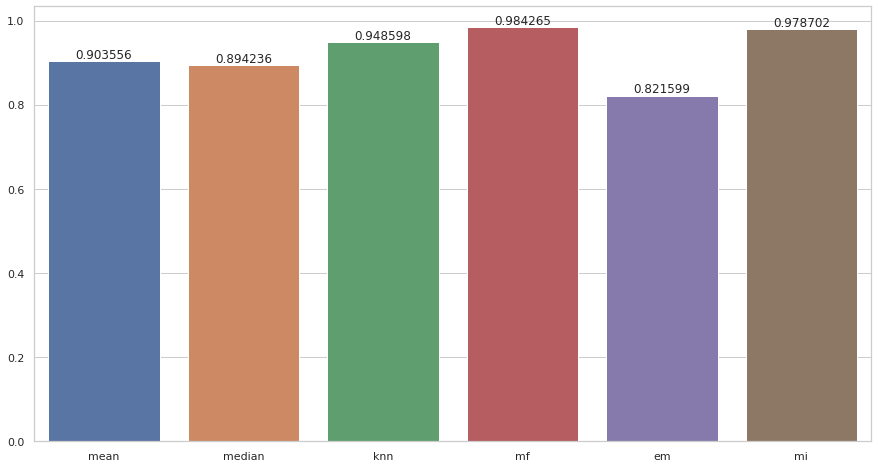

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

r2Scores = [meanR2, medianR2, knnR2, mfR2, emR2, miR2]
algos = ['mean', 'median', 'knn', 'mf', 'em', 'mi']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
ax = sns.barplot(x=algos, y=r2Scores)
ax.bar_label(ax.containers[0])

### Use MissForest to impute missing values

In [26]:
tempDf1 = dataDf.drop(['micro_specimen_id', 'person_id'], axis = 1)
mfImputer = MissForest()
mfImputedData = mfImputer.fit(tempDf1).transform(tempDf1)
mfImputedDf = pd.DataFrame(mfImputedData, columns=tempDf1.columns, index=tempDf1.index)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


In [27]:
mfImputedDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.232437,0.672591,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.905166,-1.303816,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.232437,-0.391629,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.146764,0.723268,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.094767,-0.645014,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076
7335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.422038,0.368528,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877
7336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.094767,0.925976,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391
7337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.801239,-0.391629,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943


In [28]:
tempDf2 = mfImputedDf.join(dataDf[['micro_specimen_id', 'person_id']])
tempDf2

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,micro_specimen_id,person_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177,9769904,-1046091425
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477,2985612,697543230
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943,2871076,428913244
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410,6894504,-1600246244
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177,8752252,431197671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076,1866973,2023686478
7335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877,2124103,2023686478
7336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391,5256383,2023686478
7337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943,2268946,1484033855


In [29]:
import os

outPath = os.getcwd() + '/data/data_matrix_qc_1.csv'
tempDf2.to_csv(outPath)

## Anomaly detection

### Read anomaly file from R

In [30]:
import os

anomalyPath = os.getcwd() + '/data/data_matrix_final.csv'
anomaliesDf = pd.read_csv(anomalyPath)

FileNotFoundError: [Errno 2] No such file or directory: '/superbugai-data/yash/chapter_1/workspace/ML/mortality/sepsis_micro/data/data_matrix_final.csv'

In [ ]:
anomaliesDf.head()

### Distribution of ensemble scores

In [ ]:
anomaliesDf['ensemble_scores'].hist()

### Flag anomalies from ensemble scores

In [ ]:
q1 = anomaliesDf['ensemble_scores'].quantile(0.25)
q3 = anomaliesDf['ensemble_scores'].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
anomaliesDf['anomaly'] = ((anomaliesDf['ensemble_scores'] > fence_low) & (anomaliesDf['ensemble_scores'] < fence_high))

In [ ]:
anomaliesDf.head()

### Remove anomalies

In [ ]:
outputDf = anomaliesDf[anomaliesDf.anomaly]

In [ ]:
outputDf.shape

### Create output table and dump QC data

In [2]:
dropTableQuery = """drop table if exists sepsis_micro.data_matrix_qc_2 cascade;"""
createTableQuery = """create table sepsis_micro.data_matrix_qc_2 (
"micro_specimen_id"	bigint,
"person_id"	bigint,
"discharge_mortality"	integer,
"one_day_mortality"	integer,
"two_day_mortality"	integer,
"thirty_day_mortality"	integer,
"sixty_day_mortality"	integer,
"ninety_day_mortality"	integer,
"sepsis"	integer,
"Ambulatory.Clinic...Center"	integer,
"Ambulatory.Surgical.Center"	integer,
"Emergency.Room...Hospital"	integer,
"Emergency.Room.and.Inpatient.Visit"	integer,
"Inpatient.Visit"	integer,
"Observation.Room"	integer,
"AMBULATORY.OBSERVATION"	integer,
"DIRECT.EMER."	integer,
"DIRECT.OBSERVATION"	integer,
"ELECTIVE"	integer,
"EU.OBSERVATION"	integer,
"EW.EMER."	integer,
"OBSERVATION.ADMIT"	integer,
"SURGICAL.SAME.DAY.ADMISSION"	integer,
"URGENT"	integer,
"AMBULATORY.SURGERY.TRANSFER"	integer,
"CLINIC.REFERRAL"	integer,
"EMERGENCY.ROOM"	integer,
"INFORMATION.NOT.AVAILABLE"	integer,
"INTERNAL.TRANSFER.TO.OR.FROM.PSYCH"	integer,
"PACU"	integer,
"PHYSICIAN.REFERRAL"	integer,
"PROCEDURE.SITE"	integer,
"TRANSFER.FROM.HOSPITAL"	integer,
"TRANSFER.FROM.SKILLED.NURSING.FACILITY"	integer,
"WALK.IN.SELF.REFERRAL"	integer,
"visit_duration_hrs"	numeric,
"temp_max"	numeric,
"heartrate_max"	numeric,
"breath_rate_vent_max"	numeric,
"breath_rate_spon_max"	numeric,
"resp_rate_max"	numeric,
"oxygen_max"	numeric,
"sysbp_max"	numeric,
"diabp_max"	numeric,
"meanbp_max"	numeric,
"sysbp_ni_max"	numeric,
"diabp_ni_max"	numeric,
"meanbp_ni_max"	numeric,
"gcs_motor_max"	numeric,
"gcs_verbal_max"	numeric,
"gcs_eye_max"	numeric,
"temp_min"	numeric,
"heartrate_min"	numeric,
"breath_rate_vent_min"	numeric,
"breath_rate_spon_min"	numeric,
"resp_rate_min"	numeric,
"oxygen_min"	numeric,
"sysbp_min"	numeric,
"diabp_min"	numeric,
"meanbp_min"	numeric,
"sysbp_ni_min"	numeric,
"diabp_ni_min"	numeric,
"meanbp_ni_min"	numeric,
"gcs_motor_min"	numeric,
"gcs_verbal_min"	numeric,
"gcs_eye_min"	numeric,
"temp_avg"	numeric,
"heartrate_avg"	numeric,
"breath_rate_vent_avg"	numeric,
"breath_rate_spon_avg"	numeric,
"resp_rate_avg"	numeric,
"oxygen_avg"	numeric,
"sysbp_avg"	numeric,
"diabp_avg"	numeric,
"meanbp_avg"	numeric,
"sysbp_ni_avg"	numeric,
"diabp_ni_avg"	numeric,
"meanbp_ni_avg"	numeric,
"gcs_motor_avg"	numeric,
"gcs_verbal_avg"	numeric,
"gcs_eye_avg"	numeric,
"temp_sd"	numeric,
"heartrate_sd"	numeric,
"breath_rate_vent_sd"	numeric,
"breath_rate_spon_sd"	numeric,
"resp_rate_sd"	numeric,
"oxygen_sd"	numeric,
"sysbp_sd"	numeric,
"diabp_sd"	numeric,
"meanbp_sd"	numeric,
"sysbp_ni_sd"	numeric,
"diabp_ni_sd"	numeric,
"meanbp_ni_sd"	numeric,
"gcs_motor_sd"	numeric,
"gcs_verbal_sd"	numeric,
"gcs_eye_sd"	numeric,
"temp_first"	numeric,
"heartrate_first"	numeric,
"breath_rate_vent_first"	numeric,
"breath_rate_spon_first"	numeric,
"resp_rate_first"	numeric,
"oxygen_first"	numeric,
"sysbp_first"	numeric,
"diabp_first"	numeric,
"meanbp_first"	numeric,
"sysbp_ni_first"	numeric,
"diabp_ni_first"	numeric,
"meanbp_ni_first"	numeric,
"gcs_motor_first"	numeric,
"gcs_verbal_first"	numeric,
"gcs_eye_first"	numeric,
"temp_last"	numeric,
"heartrate_last"	numeric,
"breath_rate_vent_last"	numeric,
"breath_rate_spon_last"	numeric,
"resp_rate_last"	numeric,
"oxygen_last"	numeric,
"sysbp_last"	numeric,
"diabp_last"	numeric,
"meanbp_last"	numeric,
"sysbp_ni_last"	numeric,
"diabp_ni_last"	numeric,
"meanbp_ni_last"	numeric,
"gcs_motor_last"	numeric,
"gcs_verbal_last"	numeric,
"gcs_eye_last"	numeric,
"potassium_max"	numeric,
"chloride_max"	numeric,
"glucose_max"	numeric,
"sodium_max"	numeric,
"bicarbonate_max"	numeric,
"hemoglobin_max"	numeric,
"creatinine_max"	numeric,
"potassium_min"	numeric,
"chloride_min"	numeric,
"glucose_min"	numeric,
"sodium_min"	numeric,
"bicarbonate_min"	numeric,
"hemoglobin_min"	numeric,
"creatinine_min"	numeric,
"potassium_avg"	numeric,
"chloride_avg"	numeric,
"glucose_avg"	numeric,
"sodium_avg"	numeric,
"bicarbonate_avg"	numeric,
"hemoglobin_avg"	numeric,
"creatinine_avg"	numeric,
"potassium_sd"	numeric,
"chloride_sd"	numeric,
"glucose_sd"	numeric,
"sodium_sd"	numeric,
"bicarbonate_sd"	numeric,
"hemoglobin_sd"	numeric,
"creatinine_sd"	numeric,
"potassium_first"	numeric,
"chloride_first"	numeric,
"glucose_first"	numeric,
"sodium_first"	numeric,
"bicarbonate_first"	numeric,
"hemoglobin_first"	numeric,
"creatinine_first"	numeric,
"potassium_last"	numeric,
"chloride_last"	numeric,
"glucose_last"	numeric,
"sodium_last"	numeric,
"bicarbonate_last"	numeric,
"hemoglobin_last"	numeric,
"creatinine_last"	numeric
)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [3]:
import psycopg2.extras

if len(outputDf) > 0:

    table = 'sepsis_micro.data_matrix_qc_2'

    df_columns = ['micro_specimen_id', 'person_id', 'discharge_mortality', 'one_day_mortality', 'two_day_mortality', 'thirty_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'sepsis', 'Ambulatory.Clinic...Center', 'Ambulatory.Surgical.Center', 'Emergency.Room...Hospital', 'Emergency.Room.and.Inpatient.Visit', 'Inpatient.Visit', 'Observation.Room', 'AMBULATORY.OBSERVATION', 'DIRECT.EMER.', 'DIRECT.OBSERVATION', 'ELECTIVE', 'EU.OBSERVATION', 'EW.EMER.', 'OBSERVATION.ADMIT', 'SURGICAL.SAME.DAY.ADMISSION', 'URGENT', 'AMBULATORY.SURGERY.TRANSFER', 'CLINIC.REFERRAL', 'EMERGENCY.ROOM', 'INFORMATION.NOT.AVAILABLE', 'INTERNAL.TRANSFER.TO.OR.FROM.PSYCH', 'PACU', 'PHYSICIAN.REFERRAL', 'PROCEDURE.SITE', 'TRANSFER.FROM.HOSPITAL', 'TRANSFER.FROM.SKILLED.NURSING.FACILITY', 'WALK.IN.SELF.REFERRAL', 'visit_duration_hrs', 'temp_max', 'heartrate_max', 'breath_rate_vent_max', 'breath_rate_spon_max', 'resp_rate_max', 'oxygen_max', 'sysbp_max', 'diabp_max', 'meanbp_max', 'sysbp_ni_max', 'diabp_ni_max', 'meanbp_ni_max', 'gcs_motor_max', 'gcs_verbal_max', 'gcs_eye_max', 'temp_min', 'heartrate_min', 'breath_rate_vent_min', 'breath_rate_spon_min', 'resp_rate_min', 'oxygen_min', 'sysbp_min', 'diabp_min', 'meanbp_min', 'sysbp_ni_min', 'diabp_ni_min', 'meanbp_ni_min', 'gcs_motor_min', 'gcs_verbal_min', 'gcs_eye_min', 'temp_avg', 'heartrate_avg', 'breath_rate_vent_avg', 'breath_rate_spon_avg', 'resp_rate_avg', 'oxygen_avg', 'sysbp_avg', 'diabp_avg', 'meanbp_avg', 'sysbp_ni_avg', 'diabp_ni_avg', 'meanbp_ni_avg', 'gcs_motor_avg', 'gcs_verbal_avg', 'gcs_eye_avg', 'temp_sd', 'heartrate_sd', 'breath_rate_vent_sd', 'breath_rate_spon_sd', 'resp_rate_sd', 'oxygen_sd', 'sysbp_sd', 'diabp_sd', 'meanbp_sd', 'sysbp_ni_sd', 'diabp_ni_sd', 'meanbp_ni_sd', 'gcs_motor_sd', 'gcs_verbal_sd', 'gcs_eye_sd', 'temp_first', 'heartrate_first', 'breath_rate_vent_first', 'breath_rate_spon_first', 'resp_rate_first', 'oxygen_first', 'sysbp_first', 'diabp_first', 'meanbp_first', 'sysbp_ni_first', 'diabp_ni_first', 'meanbp_ni_first', 'gcs_motor_first', 'gcs_verbal_first', 'gcs_eye_first', 'temp_last', 'heartrate_last', 'breath_rate_vent_last', 'breath_rate_spon_last', 'resp_rate_last', 'oxygen_last', 'sysbp_last', 'diabp_last', 'meanbp_last', 'sysbp_ni_last', 'diabp_ni_last', 'meanbp_ni_last', 'gcs_motor_last', 'gcs_verbal_last', 'gcs_eye_last', 'potassium_max', 'chloride_max', 'glucose_max', 'sodium_max', 'bicarbonate_max', 'hemoglobin_max', 'creatinine_max', 'potassium_min', 'chloride_min', 'glucose_min', 'sodium_min', 'bicarbonate_min', 'hemoglobin_min', 'creatinine_min', 'potassium_avg', 'chloride_avg', 'glucose_avg', 'sodium_avg', 'bicarbonate_avg', 'hemoglobin_avg', 'creatinine_avg', 'potassium_sd', 'chloride_sd', 'glucose_sd', 'sodium_sd', 'bicarbonate_sd', 'hemoglobin_sd', 'creatinine_sd', 'potassium_first', 'chloride_first', 'glucose_first', 'sodium_first', 'bicarbonate_first', 'hemoglobin_first', 'creatinine_first', 'potassium_last', 'chloride_last', 'glucose_last', 'sodium_last', 'bicarbonate_last', 'hemoglobin_last', 'creatinine_last']
    # create (col1,col2,...)
    columns = '"' + '", "'.join(df_columns) + '"'

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, outputDf[df_columns].values)
    con.commit()
    cur.close()

NameError: name 'outputDf' is not defined

## Read QC_1 File (only missing data imputation, no anomaly removal)

In [3]:
import os

dataPath = os.getcwd() + '/data/data_matrix_qc_1.csv'
dataDf = pd.read_csv(dataPath, index_col=0)
dataDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,micro_specimen_id,person_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177,9769904,-1046091425
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477,2985612,697543230
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943,2871076,428913244
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410,6894504,-1600246244
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177,8752252,431197671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076,1866973,2023686478
7335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877,2124103,2023686478
7336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391,5256383,2023686478
7337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943,2268946,1484033855


In [4]:
dropTableQuery = """drop table if exists sepsis_micro.data_matrix_qc_1 cascade;"""
createTableQuery = """create table sepsis_micro.data_matrix_qc_1 (
"micro_specimen_id" bigint,
"person_id" bigint,
"seven_day_mortality" integer,
"fourteen_day_mortality" integer,
"twentyone_day_mortality" integer,
"twentyeight_day_mortality" integer,
"sixty_day_mortality" integer,
"ninety_day_mortality" integer,
"onetwenty_day_mortality" integer,
"Ambulatory Clinic / Center" integer,
"Ambulatory Surgical Center" integer,
"Emergency Room - Hospital" integer,
"Emergency Room and Inpatient Visit" integer,
"Inpatient Visit" integer,
"Observation Room" integer,
"AMBULATORY OBSERVATION" integer,
"DIRECT EMER." integer,
"ELECTIVE" integer,
"EU OBSERVATION" integer,
"EW EMER." integer,
"OBSERVATION ADMIT" integer,
"SURGICAL SAME DAY ADMISSION" integer,
"URGENT" integer,
"AMBULATORY SURGERY TRANSFER" integer,
"CLINIC REFERRAL" integer,
"EMERGENCY ROOM" integer,
"INFORMATION NOT AVAILABLE" integer,
"INTERNAL TRANSFER TO OR FROM PSYCH" integer,
"PACU" integer,
"PHYSICIAN REFERRAL" integer,
"PROCEDURE SITE" integer,
"TRANSFER FROM HOSPITAL" integer,
"TRANSFER FROM SKILLED NURSING FACILITY" integer,
"WALK-IN/SELF REFERRAL" integer,
"visit_duration_hrs" numeric,
"temp_max" numeric,
"heartrate_max" numeric,
"breath_rate_vent_max" numeric,
"breath_rate_spon_max" numeric,
"resp_rate_max" numeric,
"oxygen_max" numeric,
"sysbp_max" numeric,
"diabp_max" numeric,
"meanbp_max" numeric,
"sysbp_ni_max" numeric,
"diabp_ni_max" numeric,
"meanbp_ni_max" numeric,
"gcs_motor_max" numeric,
"gcs_verbal_max" numeric,
"gcs_eye_max" numeric,
"temp_min" numeric,
"heartrate_min" numeric,
"breath_rate_vent_min" numeric,
"breath_rate_spon_min" numeric,
"resp_rate_min" numeric,
"oxygen_min" numeric,
"sysbp_min" numeric,
"diabp_min" numeric,
"meanbp_min" numeric,
"sysbp_ni_min" numeric,
"diabp_ni_min" numeric,
"meanbp_ni_min" numeric,
"gcs_motor_min" numeric,
"gcs_verbal_min" numeric,
"gcs_eye_min" numeric,
"temp_avg" numeric,
"heartrate_avg" numeric,
"breath_rate_vent_avg" numeric,
"breath_rate_spon_avg" numeric,
"resp_rate_avg" numeric,
"oxygen_avg" numeric,
"sysbp_avg" numeric,
"diabp_avg" numeric,
"meanbp_avg" numeric,
"sysbp_ni_avg" numeric,
"diabp_ni_avg" numeric,
"meanbp_ni_avg" numeric,
"gcs_motor_avg" numeric,
"gcs_verbal_avg" numeric,
"gcs_eye_avg" numeric,
"temp_sd" numeric,
"heartrate_sd" numeric,
"breath_rate_vent_sd" numeric,
"breath_rate_spon_sd" numeric,
"resp_rate_sd" numeric,
"oxygen_sd" numeric,
"sysbp_sd" numeric,
"diabp_sd" numeric,
"meanbp_sd" numeric,
"sysbp_ni_sd" numeric,
"diabp_ni_sd" numeric,
"meanbp_ni_sd" numeric,
"gcs_motor_sd" numeric,
"gcs_verbal_sd" numeric,
"gcs_eye_sd" numeric,
"temp_first" numeric,
"heartrate_first" numeric,
"breath_rate_vent_first" numeric,
"breath_rate_spon_first" numeric,
"resp_rate_first" numeric,
"oxygen_first" numeric,
"sysbp_first" numeric,
"diabp_first" numeric,
"meanbp_first" numeric,
"sysbp_ni_first" numeric,
"diabp_ni_first" numeric,
"meanbp_ni_first" numeric,
"gcs_motor_first" numeric,
"gcs_verbal_first" numeric,
"gcs_eye_first" numeric,
"temp_last" numeric,
"heartrate_last" numeric,
"breath_rate_vent_last" numeric,
"breath_rate_spon_last" numeric,
"resp_rate_last" numeric,
"oxygen_last" numeric,
"sysbp_last" numeric,
"diabp_last" numeric,
"meanbp_last" numeric,
"sysbp_ni_last" numeric,
"diabp_ni_last" numeric,
"meanbp_ni_last" numeric,
"gcs_motor_last" numeric,
"gcs_verbal_last" numeric,
"gcs_eye_last" numeric,
"potassium_max" numeric,
"chloride_max" numeric,
"glucose_max" numeric,
"sodium_max" numeric,
"bicarbonate_max" numeric,
"hemoglobin_max" numeric,
"creatinine_max" numeric,
"potassium_min" numeric,
"chloride_min" numeric,
"glucose_min" numeric,
"sodium_min" numeric,
"bicarbonate_min" numeric,
"hemoglobin_min" numeric,
"creatinine_min" numeric,
"potassium_avg" numeric,
"chloride_avg" numeric,
"glucose_avg" numeric,
"sodium_avg" numeric,
"bicarbonate_avg" numeric,
"hemoglobin_avg" numeric,
"creatinine_avg" numeric,
"potassium_sd" numeric,
"chloride_sd" numeric,
"glucose_sd" numeric,
"sodium_sd" numeric,
"bicarbonate_sd" numeric,
"hemoglobin_sd" numeric,
"creatinine_sd" numeric,
"potassium_first" numeric,
"chloride_first" numeric,
"glucose_first" numeric,
"sodium_first" numeric,
"bicarbonate_first" numeric,
"hemoglobin_first" numeric,
"creatinine_first" numeric,
"potassium_last" numeric,
"chloride_last" numeric,
"glucose_last" numeric,
"sodium_last" numeric,
"bicarbonate_last" numeric,
"hemoglobin_last" numeric,
"creatinine_last" numeric
)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [5]:
df_columns = [
  'micro_specimen_id',
  'person_id',
  'seven_day_mortality',
  'fourteen_day_mortality',
  'twentyone_day_mortality',
  'twentyeight_day_mortality',
  'sixty_day_mortality',
  'ninety_day_mortality',
  'onetwenty_day_mortality',
  'Ambulatory Clinic / Center',
  'Ambulatory Surgical Center',
  'Emergency Room - Hospital',
  'Emergency Room and Inpatient Visit',
  'Inpatient Visit',
  'Observation Room',
  'AMBULATORY OBSERVATION',
  'DIRECT EMER.',
  'ELECTIVE',
  'EU OBSERVATION',
  'EW EMER.',
  'OBSERVATION ADMIT',
  'SURGICAL SAME DAY ADMISSION',
  'URGENT',
  'AMBULATORY SURGERY TRANSFER',
  'CLINIC REFERRAL',
  'EMERGENCY ROOM',
  'INFORMATION NOT AVAILABLE',
  'INTERNAL TRANSFER TO OR FROM PSYCH',
  'PACU',
  'PHYSICIAN REFERRAL',
  'PROCEDURE SITE',
  'TRANSFER FROM HOSPITAL',
  'TRANSFER FROM SKILLED NURSING FACILITY',
  'WALK-IN/SELF REFERRAL',
  'visit_duration_hrs',
  'temp_max',
  'heartrate_max',
  'breath_rate_vent_max',
  'breath_rate_spon_max',
  'resp_rate_max',
  'oxygen_max',
  'sysbp_max',
  'diabp_max',
  'meanbp_max',
  'sysbp_ni_max',
  'diabp_ni_max',
  'meanbp_ni_max',
  'gcs_motor_max',
  'gcs_verbal_max',
  'gcs_eye_max',
  'temp_min',
  'heartrate_min',
  'breath_rate_vent_min',
  'breath_rate_spon_min',
  'resp_rate_min',
  'oxygen_min',
  'sysbp_min',
  'diabp_min',
  'meanbp_min',
  'sysbp_ni_min',
  'diabp_ni_min',
  'meanbp_ni_min',
  'gcs_motor_min',
  'gcs_verbal_min',
  'gcs_eye_min',
  'temp_avg',
  'heartrate_avg',
  'breath_rate_vent_avg',
  'breath_rate_spon_avg',
  'resp_rate_avg',
  'oxygen_avg',
  'sysbp_avg',
  'diabp_avg',
  'meanbp_avg',
  'sysbp_ni_avg',
  'diabp_ni_avg',
  'meanbp_ni_avg',
  'gcs_motor_avg',
  'gcs_verbal_avg',
  'gcs_eye_avg',
  'temp_sd',
  'heartrate_sd',
  'breath_rate_vent_sd',
  'breath_rate_spon_sd',
  'resp_rate_sd',
  'oxygen_sd',
  'sysbp_sd',
  'diabp_sd',
  'meanbp_sd',
  'sysbp_ni_sd',
  'diabp_ni_sd',
  'meanbp_ni_sd',
  'gcs_motor_sd',
  'gcs_verbal_sd',
  'gcs_eye_sd',
  'temp_first',
  'heartrate_first',
  'breath_rate_vent_first',
  'breath_rate_spon_first',
  'resp_rate_first',
  'oxygen_first',
  'sysbp_first',
  'diabp_first',
  'meanbp_first',
  'sysbp_ni_first',
  'diabp_ni_first',
  'meanbp_ni_first',
  'gcs_motor_first',
  'gcs_verbal_first',
  'gcs_eye_first',
  'temp_last',
  'heartrate_last',
  'breath_rate_vent_last',
  'breath_rate_spon_last',
  'resp_rate_last',
  'oxygen_last',
  'sysbp_last',
  'diabp_last',
  'meanbp_last',
  'sysbp_ni_last',
  'diabp_ni_last',
  'meanbp_ni_last',
  'gcs_motor_last',
  'gcs_verbal_last',
  'gcs_eye_last',
  'potassium_max',
  'chloride_max',
  'glucose_max',
  'sodium_max',
  'bicarbonate_max',
  'hemoglobin_max',
  'creatinine_max',
  'potassium_min',
  'chloride_min',
  'glucose_min',
  'sodium_min',
  'bicarbonate_min',
  'hemoglobin_min',
  'creatinine_min',
  'potassium_avg',
  'chloride_avg',
  'glucose_avg',
  'sodium_avg',
  'bicarbonate_avg',
  'hemoglobin_avg',
  'creatinine_avg',
  'potassium_sd',
  'chloride_sd',
  'glucose_sd',
  'sodium_sd',
  'bicarbonate_sd',
  'hemoglobin_sd',
  'creatinine_sd',
  'potassium_first',
  'chloride_first',
  'glucose_first',
  'sodium_first',
  'bicarbonate_first',
  'hemoglobin_first',
  'creatinine_first',
  'potassium_last',
  'chloride_last',
  'glucose_last',
  'sodium_last',
  'bicarbonate_last',
  'hemoglobin_last',
  'creatinine_last'
]

In [6]:
import psycopg2.extras

if len(dataDf) > 0:

    table = 'sepsis_micro.data_matrix_qc_1'

    # df_columns = ['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality',	'ninety_day_mortality',	'onetwenty_day_mortality', 'sepsis', 'Ambulatory.Clinic...Center', 'Ambulatory.Surgical.Center', 'Emergency.Room...Hospital', 'Emergency.Room.and.Inpatient.Visit', 'Inpatient.Visit', 'Observation.Room', 'AMBULATORY.OBSERVATION', 'DIRECT.EMER.', 'DIRECT.OBSERVATION', 'ELECTIVE', 'EU.OBSERVATION', 'EW.EMER.', 'OBSERVATION.ADMIT', 'SURGICAL.SAME.DAY.ADMISSION', 'URGENT', 'AMBULATORY.SURGERY.TRANSFER', 'CLINIC.REFERRAL', 'EMERGENCY.ROOM', 'INFORMATION.NOT.AVAILABLE', 'INTERNAL.TRANSFER.TO.OR.FROM.PSYCH', 'PACU', 'PHYSICIAN.REFERRAL', 'PROCEDURE.SITE', 'TRANSFER.FROM.HOSPITAL', 'TRANSFER.FROM.SKILLED.NURSING.FACILITY', 'WALK.IN.SELF.REFERRAL', 'visit_duration_hrs', 'temp_max', 'heartrate_max', 'breath_rate_vent_max', 'breath_rate_spon_max', 'resp_rate_max', 'oxygen_max', 'sysbp_max', 'diabp_max', 'meanbp_max', 'sysbp_ni_max', 'diabp_ni_max', 'meanbp_ni_max', 'gcs_motor_max', 'gcs_verbal_max', 'gcs_eye_max', 'temp_min', 'heartrate_min', 'breath_rate_vent_min', 'breath_rate_spon_min', 'resp_rate_min', 'oxygen_min', 'sysbp_min', 'diabp_min', 'meanbp_min', 'sysbp_ni_min', 'diabp_ni_min', 'meanbp_ni_min', 'gcs_motor_min', 'gcs_verbal_min', 'gcs_eye_min', 'temp_avg', 'heartrate_avg', 'breath_rate_vent_avg', 'breath_rate_spon_avg', 'resp_rate_avg', 'oxygen_avg', 'sysbp_avg', 'diabp_avg', 'meanbp_avg', 'sysbp_ni_avg', 'diabp_ni_avg', 'meanbp_ni_avg', 'gcs_motor_avg', 'gcs_verbal_avg', 'gcs_eye_avg', 'temp_sd', 'heartrate_sd', 'breath_rate_vent_sd', 'breath_rate_spon_sd', 'resp_rate_sd', 'oxygen_sd', 'sysbp_sd', 'diabp_sd', 'meanbp_sd', 'sysbp_ni_sd', 'diabp_ni_sd', 'meanbp_ni_sd', 'gcs_motor_sd', 'gcs_verbal_sd', 'gcs_eye_sd', 'temp_first', 'heartrate_first', 'breath_rate_vent_first', 'breath_rate_spon_first', 'resp_rate_first', 'oxygen_first', 'sysbp_first', 'diabp_first', 'meanbp_first', 'sysbp_ni_first', 'diabp_ni_first', 'meanbp_ni_first', 'gcs_motor_first', 'gcs_verbal_first', 'gcs_eye_first', 'temp_last', 'heartrate_last', 'breath_rate_vent_last', 'breath_rate_spon_last', 'resp_rate_last', 'oxygen_last', 'sysbp_last', 'diabp_last', 'meanbp_last', 'sysbp_ni_last', 'diabp_ni_last', 'meanbp_ni_last', 'gcs_motor_last', 'gcs_verbal_last', 'gcs_eye_last', 'potassium_max', 'chloride_max', 'glucose_max', 'sodium_max', 'bicarbonate_max', 'hemoglobin_max', 'creatinine_max', 'potassium_min', 'chloride_min', 'glucose_min', 'sodium_min', 'bicarbonate_min', 'hemoglobin_min', 'creatinine_min', 'potassium_avg', 'chloride_avg', 'glucose_avg', 'sodium_avg', 'bicarbonate_avg', 'hemoglobin_avg', 'creatinine_avg', 'potassium_sd', 'chloride_sd', 'glucose_sd', 'sodium_sd', 'bicarbonate_sd', 'hemoglobin_sd', 'creatinine_sd', 'potassium_first', 'chloride_first', 'glucose_first', 'sodium_first', 'bicarbonate_first', 'hemoglobin_first', 'creatinine_first', 'potassium_last', 'chloride_last', 'glucose_last', 'sodium_last', 'bicarbonate_last', 'hemoglobin_last', 'creatinine_last']
    # create (col1,col2,...)
    columns = '"' + '", "'.join(df_columns) + '"'

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, dataDf[df_columns].values)
    con.commit()
    cur.close()

## Read Without QC File

In [7]:
import os

originalPath = os.getcwd() + '/data/data_matrix_no_qc.csv'
originalDf = pd.read_csv(originalPath, index_col=0)
originalDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,9769904,-1046091425,0,0,0,0,0,0,0,0,...,0.232437,0.672591,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177
1,2985612,697543230,0,0,0,0,0,0,0,0,...,-0.905166,-1.303816,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477
2,2871076,428913244,0,0,0,0,0,0,0,0,...,0.232437,-0.391629,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943
3,6894504,-1600246244,0,0,0,0,1,1,1,0,...,-0.146764,0.723268,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410
4,8752252,431197671,1,1,1,1,1,1,1,0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,1866973,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,-0.645014,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076
7335,2124103,2023686478,0,0,0,0,0,0,0,0,...,0.422038,0.368528,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877
7336,5256383,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,0.925976,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391
7337,2268946,1484033855,0,0,0,0,0,0,0,0,...,0.801239,-0.391629,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943


In [8]:
dropTableQuery = """drop table if exists sepsis_micro.data_matrix_no_qc cascade;"""
createTableQuery = """create table sepsis_micro.data_matrix_no_qc (
"micro_specimen_id" bigint,
"person_id" bigint,
"seven_day_mortality" integer,
"fourteen_day_mortality" integer,
"twentyone_day_mortality" integer,
"twentyeight_day_mortality" integer,
"sixty_day_mortality" integer,
"ninety_day_mortality" integer,
"onetwenty_day_mortality" integer,
"Ambulatory Clinic / Center" integer,
"Ambulatory Surgical Center" integer,
"Emergency Room - Hospital" integer,
"Emergency Room and Inpatient Visit" integer,
"Inpatient Visit" integer,
"Observation Room" integer,
"AMBULATORY OBSERVATION" integer,
"DIRECT EMER." integer,
"ELECTIVE" integer,
"EU OBSERVATION" integer,
"EW EMER." integer,
"OBSERVATION ADMIT" integer,
"SURGICAL SAME DAY ADMISSION" integer,
"URGENT" integer,
"AMBULATORY SURGERY TRANSFER" integer,
"CLINIC REFERRAL" integer,
"EMERGENCY ROOM" integer,
"INFORMATION NOT AVAILABLE" integer,
"INTERNAL TRANSFER TO OR FROM PSYCH" integer,
"PACU" integer,
"PHYSICIAN REFERRAL" integer,
"PROCEDURE SITE" integer,
"TRANSFER FROM HOSPITAL" integer,
"TRANSFER FROM SKILLED NURSING FACILITY" integer,
"WALK-IN/SELF REFERRAL" integer,
"visit_duration_hrs" numeric,
"temp_max" numeric,
"heartrate_max" numeric,
"breath_rate_vent_max" numeric,
"breath_rate_spon_max" numeric,
"resp_rate_max" numeric,
"oxygen_max" numeric,
"sysbp_max" numeric,
"diabp_max" numeric,
"meanbp_max" numeric,
"sysbp_ni_max" numeric,
"diabp_ni_max" numeric,
"meanbp_ni_max" numeric,
"gcs_motor_max" numeric,
"gcs_verbal_max" numeric,
"gcs_eye_max" numeric,
"temp_min" numeric,
"heartrate_min" numeric,
"breath_rate_vent_min" numeric,
"breath_rate_spon_min" numeric,
"resp_rate_min" numeric,
"oxygen_min" numeric,
"sysbp_min" numeric,
"diabp_min" numeric,
"meanbp_min" numeric,
"sysbp_ni_min" numeric,
"diabp_ni_min" numeric,
"meanbp_ni_min" numeric,
"gcs_motor_min" numeric,
"gcs_verbal_min" numeric,
"gcs_eye_min" numeric,
"temp_avg" numeric,
"heartrate_avg" numeric,
"breath_rate_vent_avg" numeric,
"breath_rate_spon_avg" numeric,
"resp_rate_avg" numeric,
"oxygen_avg" numeric,
"sysbp_avg" numeric,
"diabp_avg" numeric,
"meanbp_avg" numeric,
"sysbp_ni_avg" numeric,
"diabp_ni_avg" numeric,
"meanbp_ni_avg" numeric,
"gcs_motor_avg" numeric,
"gcs_verbal_avg" numeric,
"gcs_eye_avg" numeric,
"temp_sd" numeric,
"heartrate_sd" numeric,
"breath_rate_vent_sd" numeric,
"breath_rate_spon_sd" numeric,
"resp_rate_sd" numeric,
"oxygen_sd" numeric,
"sysbp_sd" numeric,
"diabp_sd" numeric,
"meanbp_sd" numeric,
"sysbp_ni_sd" numeric,
"diabp_ni_sd" numeric,
"meanbp_ni_sd" numeric,
"gcs_motor_sd" numeric,
"gcs_verbal_sd" numeric,
"gcs_eye_sd" numeric,
"temp_first" numeric,
"heartrate_first" numeric,
"breath_rate_vent_first" numeric,
"breath_rate_spon_first" numeric,
"resp_rate_first" numeric,
"oxygen_first" numeric,
"sysbp_first" numeric,
"diabp_first" numeric,
"meanbp_first" numeric,
"sysbp_ni_first" numeric,
"diabp_ni_first" numeric,
"meanbp_ni_first" numeric,
"gcs_motor_first" numeric,
"gcs_verbal_first" numeric,
"gcs_eye_first" numeric,
"temp_last" numeric,
"heartrate_last" numeric,
"breath_rate_vent_last" numeric,
"breath_rate_spon_last" numeric,
"resp_rate_last" numeric,
"oxygen_last" numeric,
"sysbp_last" numeric,
"diabp_last" numeric,
"meanbp_last" numeric,
"sysbp_ni_last" numeric,
"diabp_ni_last" numeric,
"meanbp_ni_last" numeric,
"gcs_motor_last" numeric,
"gcs_verbal_last" numeric,
"gcs_eye_last" numeric,
"potassium_max" numeric,
"chloride_max" numeric,
"glucose_max" numeric,
"sodium_max" numeric,
"bicarbonate_max" numeric,
"hemoglobin_max" numeric,
"creatinine_max" numeric,
"potassium_min" numeric,
"chloride_min" numeric,
"glucose_min" numeric,
"sodium_min" numeric,
"bicarbonate_min" numeric,
"hemoglobin_min" numeric,
"creatinine_min" numeric,
"potassium_avg" numeric,
"chloride_avg" numeric,
"glucose_avg" numeric,
"sodium_avg" numeric,
"bicarbonate_avg" numeric,
"hemoglobin_avg" numeric,
"creatinine_avg" numeric,
"potassium_sd" numeric,
"chloride_sd" numeric,
"glucose_sd" numeric,
"sodium_sd" numeric,
"bicarbonate_sd" numeric,
"hemoglobin_sd" numeric,
"creatinine_sd" numeric,
"potassium_first" numeric,
"chloride_first" numeric,
"glucose_first" numeric,
"sodium_first" numeric,
"bicarbonate_first" numeric,
"hemoglobin_first" numeric,
"creatinine_first" numeric,
"potassium_last" numeric,
"chloride_last" numeric,
"glucose_last" numeric,
"sodium_last" numeric,
"bicarbonate_last" numeric,
"hemoglobin_last" numeric,
"creatinine_last" numeric
)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [9]:
df_columns = [
  'micro_specimen_id',
  'person_id',
  'seven_day_mortality',
  'fourteen_day_mortality',
  'twentyone_day_mortality',
  'twentyeight_day_mortality',
  'sixty_day_mortality',
  'ninety_day_mortality',
  'onetwenty_day_mortality',
  'Ambulatory Clinic / Center',
  'Ambulatory Surgical Center',
  'Emergency Room - Hospital',
  'Emergency Room and Inpatient Visit',
  'Inpatient Visit',
  'Observation Room',
  'AMBULATORY OBSERVATION',
  'DIRECT EMER.',
  'ELECTIVE',
  'EU OBSERVATION',
  'EW EMER.',
  'OBSERVATION ADMIT',
  'SURGICAL SAME DAY ADMISSION',
  'URGENT',
  'AMBULATORY SURGERY TRANSFER',
  'CLINIC REFERRAL',
  'EMERGENCY ROOM',
  'INFORMATION NOT AVAILABLE',
  'INTERNAL TRANSFER TO OR FROM PSYCH',
  'PACU',
  'PHYSICIAN REFERRAL',
  'PROCEDURE SITE',
  'TRANSFER FROM HOSPITAL',
  'TRANSFER FROM SKILLED NURSING FACILITY',
  'WALK-IN/SELF REFERRAL',
  'visit_duration_hrs',
  'temp_max',
  'heartrate_max',
  'breath_rate_vent_max',
  'breath_rate_spon_max',
  'resp_rate_max',
  'oxygen_max',
  'sysbp_max',
  'diabp_max',
  'meanbp_max',
  'sysbp_ni_max',
  'diabp_ni_max',
  'meanbp_ni_max',
  'gcs_motor_max',
  'gcs_verbal_max',
  'gcs_eye_max',
  'temp_min',
  'heartrate_min',
  'breath_rate_vent_min',
  'breath_rate_spon_min',
  'resp_rate_min',
  'oxygen_min',
  'sysbp_min',
  'diabp_min',
  'meanbp_min',
  'sysbp_ni_min',
  'diabp_ni_min',
  'meanbp_ni_min',
  'gcs_motor_min',
  'gcs_verbal_min',
  'gcs_eye_min',
  'temp_avg',
  'heartrate_avg',
  'breath_rate_vent_avg',
  'breath_rate_spon_avg',
  'resp_rate_avg',
  'oxygen_avg',
  'sysbp_avg',
  'diabp_avg',
  'meanbp_avg',
  'sysbp_ni_avg',
  'diabp_ni_avg',
  'meanbp_ni_avg',
  'gcs_motor_avg',
  'gcs_verbal_avg',
  'gcs_eye_avg',
  'temp_sd',
  'heartrate_sd',
  'breath_rate_vent_sd',
  'breath_rate_spon_sd',
  'resp_rate_sd',
  'oxygen_sd',
  'sysbp_sd',
  'diabp_sd',
  'meanbp_sd',
  'sysbp_ni_sd',
  'diabp_ni_sd',
  'meanbp_ni_sd',
  'gcs_motor_sd',
  'gcs_verbal_sd',
  'gcs_eye_sd',
  'temp_first',
  'heartrate_first',
  'breath_rate_vent_first',
  'breath_rate_spon_first',
  'resp_rate_first',
  'oxygen_first',
  'sysbp_first',
  'diabp_first',
  'meanbp_first',
  'sysbp_ni_first',
  'diabp_ni_first',
  'meanbp_ni_first',
  'gcs_motor_first',
  'gcs_verbal_first',
  'gcs_eye_first',
  'temp_last',
  'heartrate_last',
  'breath_rate_vent_last',
  'breath_rate_spon_last',
  'resp_rate_last',
  'oxygen_last',
  'sysbp_last',
  'diabp_last',
  'meanbp_last',
  'sysbp_ni_last',
  'diabp_ni_last',
  'meanbp_ni_last',
  'gcs_motor_last',
  'gcs_verbal_last',
  'gcs_eye_last',
  'potassium_max',
  'chloride_max',
  'glucose_max',
  'sodium_max',
  'bicarbonate_max',
  'hemoglobin_max',
  'creatinine_max',
  'potassium_min',
  'chloride_min',
  'glucose_min',
  'sodium_min',
  'bicarbonate_min',
  'hemoglobin_min',
  'creatinine_min',
  'potassium_avg',
  'chloride_avg',
  'glucose_avg',
  'sodium_avg',
  'bicarbonate_avg',
  'hemoglobin_avg',
  'creatinine_avg',
  'potassium_sd',
  'chloride_sd',
  'glucose_sd',
  'sodium_sd',
  'bicarbonate_sd',
  'hemoglobin_sd',
  'creatinine_sd',
  'potassium_first',
  'chloride_first',
  'glucose_first',
  'sodium_first',
  'bicarbonate_first',
  'hemoglobin_first',
  'creatinine_first',
  'potassium_last',
  'chloride_last',
  'glucose_last',
  'sodium_last',
  'bicarbonate_last',
  'hemoglobin_last',
  'creatinine_last'
]

In [10]:
import psycopg2.extras

if len(originalDf) > 0:

    table = 'sepsis_micro.data_matrix_no_qc'

    # df_columns = ['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality',	'ninety_day_mortality',	'onetwenty_day_mortality', 'sepsis', 'Ambulatory.Clinic...Center', 'Ambulatory.Surgical.Center', 'Emergency.Room...Hospital', 'Emergency.Room.and.Inpatient.Visit', 'Inpatient.Visit', 'Observation.Room', 'AMBULATORY.OBSERVATION', 'DIRECT.EMER.', 'DIRECT.OBSERVATION', 'ELECTIVE', 'EU.OBSERVATION', 'EW.EMER.', 'OBSERVATION.ADMIT', 'SURGICAL.SAME.DAY.ADMISSION', 'URGENT', 'AMBULATORY.SURGERY.TRANSFER', 'CLINIC.REFERRAL', 'EMERGENCY.ROOM', 'INFORMATION.NOT.AVAILABLE', 'INTERNAL.TRANSFER.TO.OR.FROM.PSYCH', 'PACU', 'PHYSICIAN.REFERRAL', 'PROCEDURE.SITE', 'TRANSFER.FROM.HOSPITAL', 'TRANSFER.FROM.SKILLED.NURSING.FACILITY', 'WALK.IN.SELF.REFERRAL', 'visit_duration_hrs', 'temp_max', 'heartrate_max', 'breath_rate_vent_max', 'breath_rate_spon_max', 'resp_rate_max', 'oxygen_max', 'sysbp_max', 'diabp_max', 'meanbp_max', 'sysbp_ni_max', 'diabp_ni_max', 'meanbp_ni_max', 'gcs_motor_max', 'gcs_verbal_max', 'gcs_eye_max', 'temp_min', 'heartrate_min', 'breath_rate_vent_min', 'breath_rate_spon_min', 'resp_rate_min', 'oxygen_min', 'sysbp_min', 'diabp_min', 'meanbp_min', 'sysbp_ni_min', 'diabp_ni_min', 'meanbp_ni_min', 'gcs_motor_min', 'gcs_verbal_min', 'gcs_eye_min', 'temp_avg', 'heartrate_avg', 'breath_rate_vent_avg', 'breath_rate_spon_avg', 'resp_rate_avg', 'oxygen_avg', 'sysbp_avg', 'diabp_avg', 'meanbp_avg', 'sysbp_ni_avg', 'diabp_ni_avg', 'meanbp_ni_avg', 'gcs_motor_avg', 'gcs_verbal_avg', 'gcs_eye_avg', 'temp_sd', 'heartrate_sd', 'breath_rate_vent_sd', 'breath_rate_spon_sd', 'resp_rate_sd', 'oxygen_sd', 'sysbp_sd', 'diabp_sd', 'meanbp_sd', 'sysbp_ni_sd', 'diabp_ni_sd', 'meanbp_ni_sd', 'gcs_motor_sd', 'gcs_verbal_sd', 'gcs_eye_sd', 'temp_first', 'heartrate_first', 'breath_rate_vent_first', 'breath_rate_spon_first', 'resp_rate_first', 'oxygen_first', 'sysbp_first', 'diabp_first', 'meanbp_first', 'sysbp_ni_first', 'diabp_ni_first', 'meanbp_ni_first', 'gcs_motor_first', 'gcs_verbal_first', 'gcs_eye_first', 'temp_last', 'heartrate_last', 'breath_rate_vent_last', 'breath_rate_spon_last', 'resp_rate_last', 'oxygen_last', 'sysbp_last', 'diabp_last', 'meanbp_last', 'sysbp_ni_last', 'diabp_ni_last', 'meanbp_ni_last', 'gcs_motor_last', 'gcs_verbal_last', 'gcs_eye_last', 'potassium_max', 'chloride_max', 'glucose_max', 'sodium_max', 'bicarbonate_max', 'hemoglobin_max', 'creatinine_max', 'potassium_min', 'chloride_min', 'glucose_min', 'sodium_min', 'bicarbonate_min', 'hemoglobin_min', 'creatinine_min', 'potassium_avg', 'chloride_avg', 'glucose_avg', 'sodium_avg', 'bicarbonate_avg', 'hemoglobin_avg', 'creatinine_avg', 'potassium_sd', 'chloride_sd', 'glucose_sd', 'sodium_sd', 'bicarbonate_sd', 'hemoglobin_sd', 'creatinine_sd', 'potassium_first', 'chloride_first', 'glucose_first', 'sodium_first', 'bicarbonate_first', 'hemoglobin_first', 'creatinine_first', 'potassium_last', 'chloride_last', 'glucose_last', 'sodium_last', 'bicarbonate_last', 'hemoglobin_last', 'creatinine_last']
    # create (col1,col2,...)
    columns = '"' + '", "'.join(df_columns) + '"'

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, originalDf[df_columns].values)
    con.commit()
    cur.close()

## Beep

In [11]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('https://www.soundjay.com/buttons/beep-01a.wav', autoplay=True))
beep();